# Ensemble Model

Reading the classification dataset created on notebook 1

Reference:

Seminar 01 (week 02): page 13

In [68]:
import pandas as pd

# reading the datatset
data = pd.read_csv('/content/drive/MyDrive/IIT /Level 5/Semester 2/Machine Learning & Data Mining/CW/final/classification_data.csv')
data.head()

,Age,Sex,T_Stage,N_Stage,6th_Stage,Differentiated,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Mortality_Status
0,1.561311,0,-1.024893,-0.631472,-1.042623,1.329513,1.329513,0,-1.254637,1,1,1.186013,-0.618154,1
1,-0.446375,0,0.282269,0.812355,0.537944,-0.237720,-0.237720,0,0.216515,1,1,-0.044437,0.167067,1
2,0.445930,0,1.589430,2.256182,2.118510,-0.237720,-0.237720,0,1.545298,1,1,-0.044437,0.559678,1
3,0.445930,0,-1.024893,-0.631472,-1.042623,1.329513,1.329513,0,-0.590246,1,1,-1.520977,-0.618154,1
4,-0.780989,0,0.282269,-0.631472,-0.252339,1.329513,1.329513,0,0.501255,1,1,-1.397932,-0.618154,1


Splitting the dataset for the classification task on the ensemble model

Reference:

Seminar 02 (week 03): page 05

In [69]:
from sklearn.model_selection import train_test_split

# spliting the dataset
X = data.drop('Mortality_Status', axis=1)
y = data['Mortality_Status']

# stratify to maintain the class percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#This is to show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)

X_train Instances (3212, 13)
X_test Instances (803, 13)


LR and NB were choosen as base learner the reasons were discussed on notebook 2 itself. There were 2 LR models with kind of the same performance on notebook 2.
1. LR built on class_weight='balanced'
2. LR built on rebalanced train split

both of these strategies were used to deal with imbalanced data. Since NB is built on resampled train split, I choose the resampled LR as well to maintain the same conditions (when training the base learners) on base learners.

Using pickle to import the models that we exported in notebook 2.

Reference:

Subash A. (2023). Saving and Loading Trained Machine Learning Models with Python: A Comprehensive Guide. Medium. Available from https://medium.com/@subashdhoni86/saving-and-loading-trained-machine-learning-models-with-python-a-comprehensive-guide-b6e661b4ec01 .

In [72]:
# Load your models
import pickle

# Load Logistic Regression model
with open('/content/drive/MyDrive/IIT /Level 5/Semester 2/Machine Learning & Data Mining/CW/final/logreg_model_tuned.pkl', 'rb') as f:
    logreg_model = pickle.load(f)

# Load Gaussian Naive Bayes model
with open('/content/drive/MyDrive/IIT /Level 5/Semester 2/Machine Learning & Data Mining/CW/final/nb_model.pkl', 'rb') as f:
    nb_model = pickle.load(f)

Checking the performance metrics to make sure that we have the right models

Reference:

Seminar 02 (week 03): page 10, 11


Final LR model performance:
              precision    recall  f1-score   support

           0       0.31      0.73      0.44       123
           1       0.94      0.71      0.81       680

    accuracy                           0.71       803
   macro avg       0.62      0.72      0.62       803
weighted avg       0.84      0.71      0.75       803



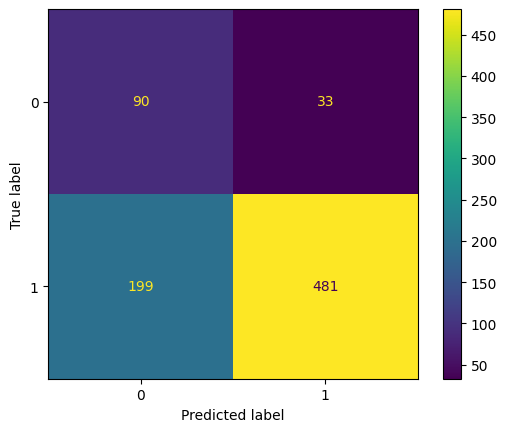

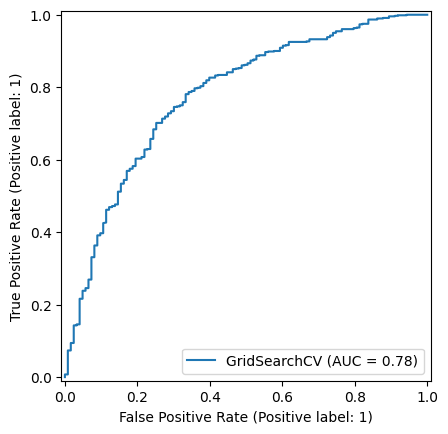

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report

lr_pred = logreg_model.predict(X_test)
print("\nFinal LR model performance:")
print(classification_report(y_test, lr_pred))

# Plot confusion matrix
final_cm = confusion_matrix(y_test, lr_pred, labels=logreg_model.classes_)
final_disp = ConfusionMatrixDisplay(final_cm, display_labels=logreg_model.classes_)
final_disp.plot()

knn_roc = RocCurveDisplay.from_estimator(logreg_model, X_test, y_test)

Reference:

Seminar 03 (week 04): page 15, 16


Final NB model performance:
              precision    recall  f1-score   support

           0       0.32      0.57      0.41       123
           1       0.91      0.78      0.84       680

    accuracy                           0.75       803
   macro avg       0.62      0.68      0.63       803
weighted avg       0.82      0.75      0.78       803



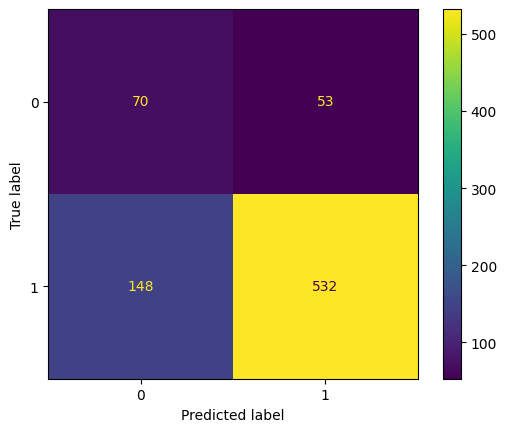

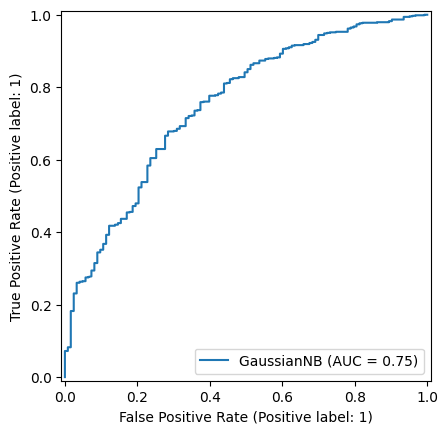

In [74]:
nb_pred = nb_model.predict(X_test)
print("\nFinal NB model performance:")
print(classification_report(y_test, nb_pred))

# Plot confusion matrix
final_cm = confusion_matrix(y_test, nb_pred, labels=nb_model.classes_)
final_disp = ConfusionMatrixDisplay(final_cm, display_labels=nb_model.classes_)
final_disp.plot()

knn_roc = RocCurveDisplay.from_estimator(nb_model, X_test, y_test)

Using SMOtE to balance the dataset, cause the classes are heavily imbalanced

Reference:

SMOTE for Imbalanced Classification with Python. (2024). GeeksforGeeks. Available from https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/.

In [75]:
from imblearn.over_sampling import SMOTE

# oversampling only the minority class
smote=SMOTE(sampling_strategy='minority')

X_train_resampled, y_train_resampled=smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

,count
Mortality_Status,
1,2720
0,2720


Creating the ensemble model

Reference:

Seminar 07 (week 08): page 06

In [76]:
#initiate a new ensemble model
from sklearn.ensemble import VotingClassifier

#create a dictionary of our base learner models
base_learners=[('NB', nb_model), ('LR', logreg_model)]

#create our voting classifier, inputting our models
ensemble_learner = VotingClassifier(base_learners, voting='soft')

#fit model to training data
ensemble_learner = ensemble_learner.fit(X_train_resampled, y_train_resampled)
y_pred_ensembler = ensemble_learner.predict(X_test)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


Evaluating the ensemble model

Reference:

Seminar 07 (week 08): page 07

Classification report for Ensmebler
              precision    recall  f1-score   support

           0       0.34      0.62      0.44       123
           1       0.92      0.78      0.84       680

    accuracy                           0.75       803
   macro avg       0.63      0.70      0.64       803
weighted avg       0.83      0.75      0.78       803

confusion_matrix for ensember learner


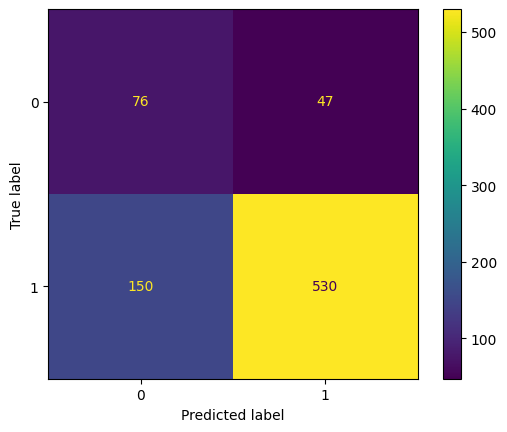

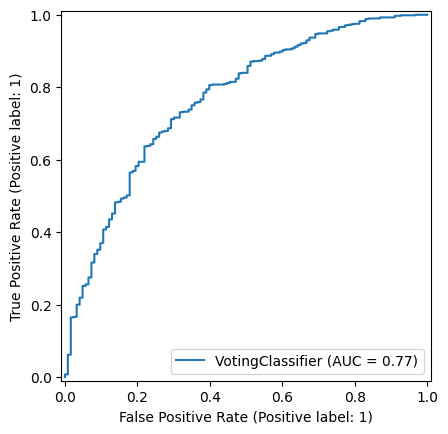

In [77]:
# Evaluating the ensemble model by generating the classification report and the confusion matrix
print("Classification report for Ensmebler")
print(classification_report(y_test,y_pred_ensembler))

print("confusion_matrix for ensember learner")
ensemble_learner_cm=confusion_matrix(y_test,y_pred_ensembler)
disp=ConfusionMatrixDisplay(confusion_matrix=ensemble_learner_cm,display_labels = ensemble_learner.classes_)
disp.plot()

ensembler_roc = RocCurveDisplay.from_estimator(ensemble_learner, X_test, y_test)

The ensemble model is better and generalised model comparing to the other base models, it has an intermediate performance comparing the base learners.

## Decision Trees (Regression task)

Reading the regression dataset created on notebook 1

Reference:

Seminar 01 (week 02): page 13

In [86]:
# reading the regression dataset
reg_data = pd.read_csv('/content/drive/MyDrive/IIT /Level 5/Semester 2/Machine Learning & Data Mining/CW/final/regression_data.csv')
reg_data.head()

,Age,Sex,T_Stage,N_Stage,6th_Stage,Differentiated,Grade,A_Stage,Tumor_Size,Estrogen_Status,Progesterone_Status,Regional_Node_Examined,Reginol_Node_Positive,Survival_Months
0,-1.560989,0,0.282231,-0.631712,-0.252757,-0.237688,-0.237688,0,-0.020694,1,1,-0.659932,-0.618431,14
1,1.561378,0,-1.025080,-0.631712,-1.042698,-0.237688,-0.237688,0,-0.827546,1,1,-0.659932,-0.618431,64
2,0.334734,0,1.589542,2.254472,2.117064,-0.237688,-0.237688,0,1.877782,1,1,-0.290846,1.540385,42
3,-1.337963,0,-1.025080,2.254472,2.117064,-0.237688,-0.237688,0,-1.017394,0,0,0.078241,-0.422175,39
4,1.449865,0,-1.025080,-0.631712,-1.042698,-0.237688,-0.237688,0,-0.827546,1,1,0.201270,-0.225919,60


Printing all the columns on the data frame

Reference:

Seminar 01 (week 02): page 14

In [87]:
list(reg_data.columns)

['Age',
 'Sex',
 'T_Stage',
 'N_Stage',
 '6th_Stage',
 'Differentiated',
 'Grade',
 'A_Stage',
 'Tumor_Size',
 'Estrogen_Status',
 'Progesterone_Status',
 'Regional_Node_Examined',
 'Reginol_Node_Positive',
 'Survival_Months']

Printing the dimensions of the data frame

Reference:

Seminar 01 (week 02): page 15

In [88]:
reg_data.shape

(615, 14)

Splitting the data into training and testing splits



In [89]:
from sklearn.model_selection import train_test_split

# spliting the dataset
X = reg_data.drop('Survival_Months', axis=1)
y = reg_data['Survival_Months']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This is to show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)

X_train Instances (492, 13)
X_test Instances (123, 13)


Creating the fully grown unpruned DT

Reference:

Seminar 06 (week 07): page 13

In [90]:
from sklearn.tree import DecisionTreeRegressor

# Initializing and fitting fully grown unpruned DT
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Making predicitons on the test split
y_pred = regressor.predict(X_test)

# Displaying the full tree depth
print("The full Regression Decision Tree Levels: ", regressor.tree_.max_depth)

The full Regression Decision Tree Levels:  22


Plotting the fully grown tree

Reference:

Seminar 06 (week 07): page 13

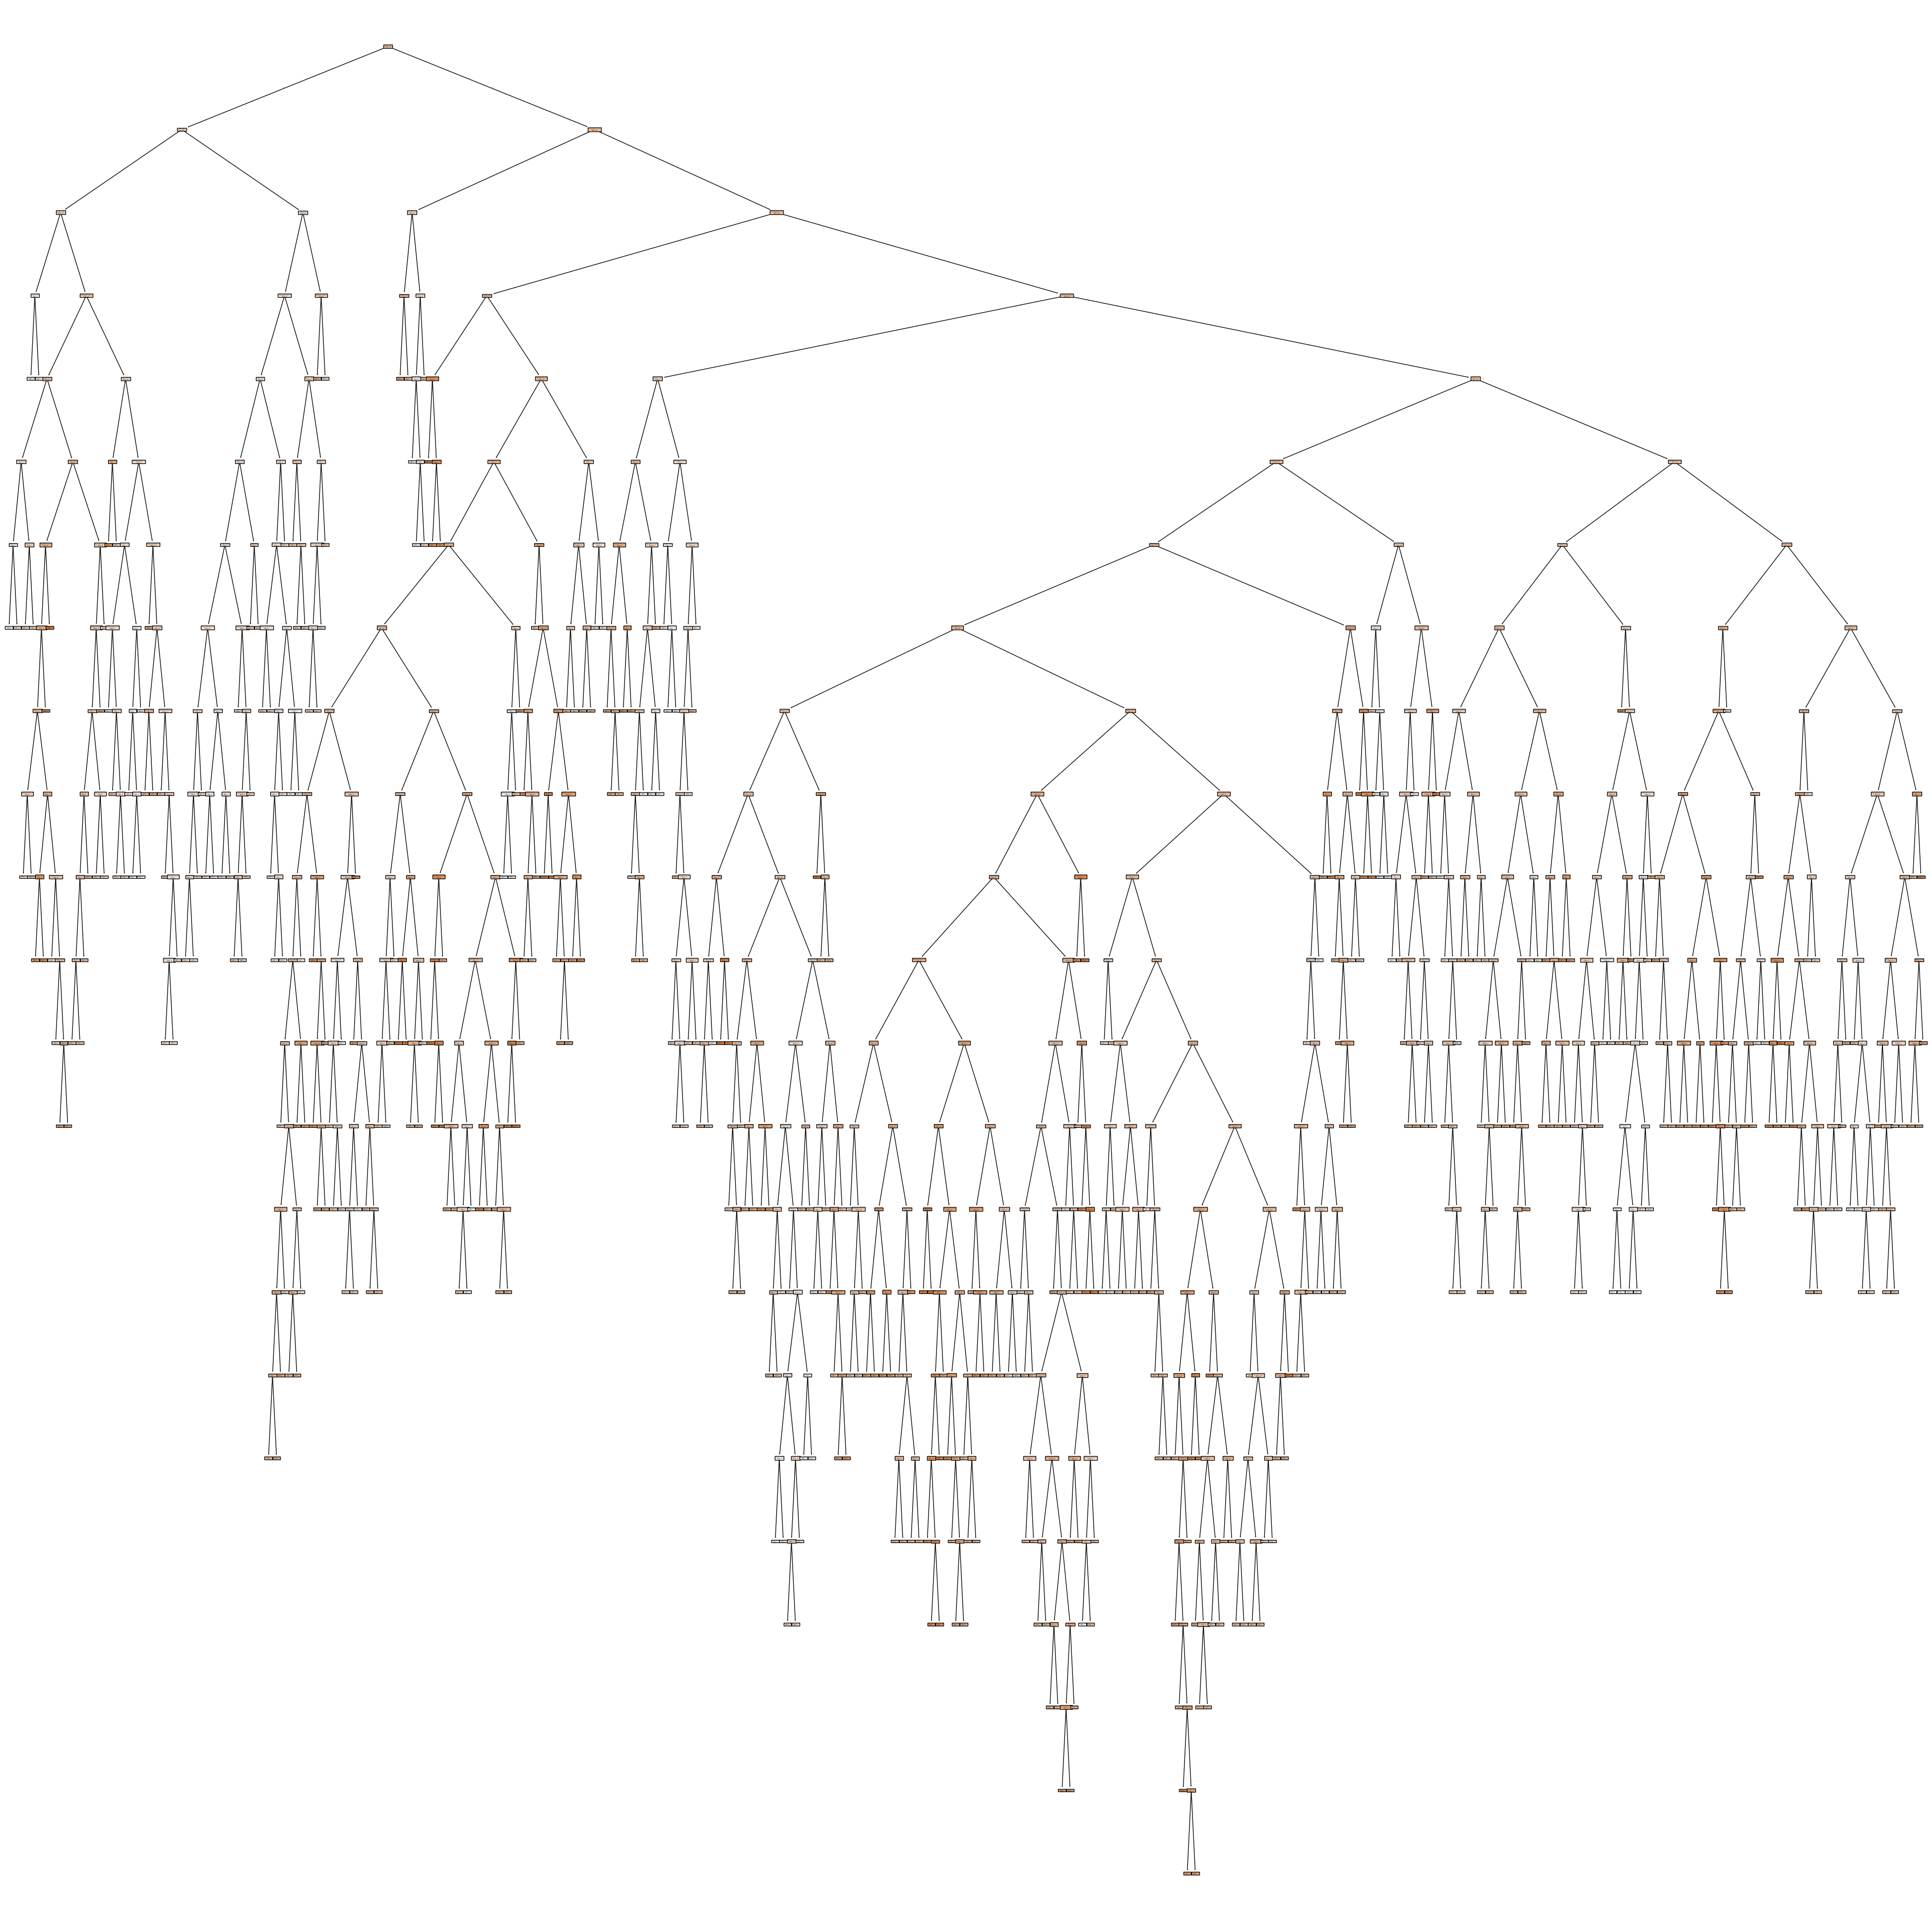

In [91]:
from matplotlib import pyplot as plt
from sklearn import tree

# Plotting the regression DT
unpruned_Tree_model = plt.figure(figsize=(50,50))
unpruned_Tree_model_Graph = tree.plot_tree(regressor, feature_names=list(X_train.columns), filled=True)

# Saving the tree as a PNG image
plt.savefig("unpruned_regression_tree.png", format='png')

Evaluating the fully grown DT

Reference:

Seminar 06 (week 07): page 20

In [92]:
from sklearn import metrics
import numpy as np

# Calculating the regression metrics for the fully grown regression decision Tree
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 29.471544715447155
Mean Squared Error: 1258.1544715447155
R2: -1.3628940376913659


Creating a pruned DT

Reference:

Seminar 06 (week 07): page 19

In [93]:
# Limiting the tree growth to 4 levels
pruned_regressor = DecisionTreeRegressor(max_depth=4)
pruned_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

Plotting unpruned DT

Reference:

Seminar 06 (week 07): page 20

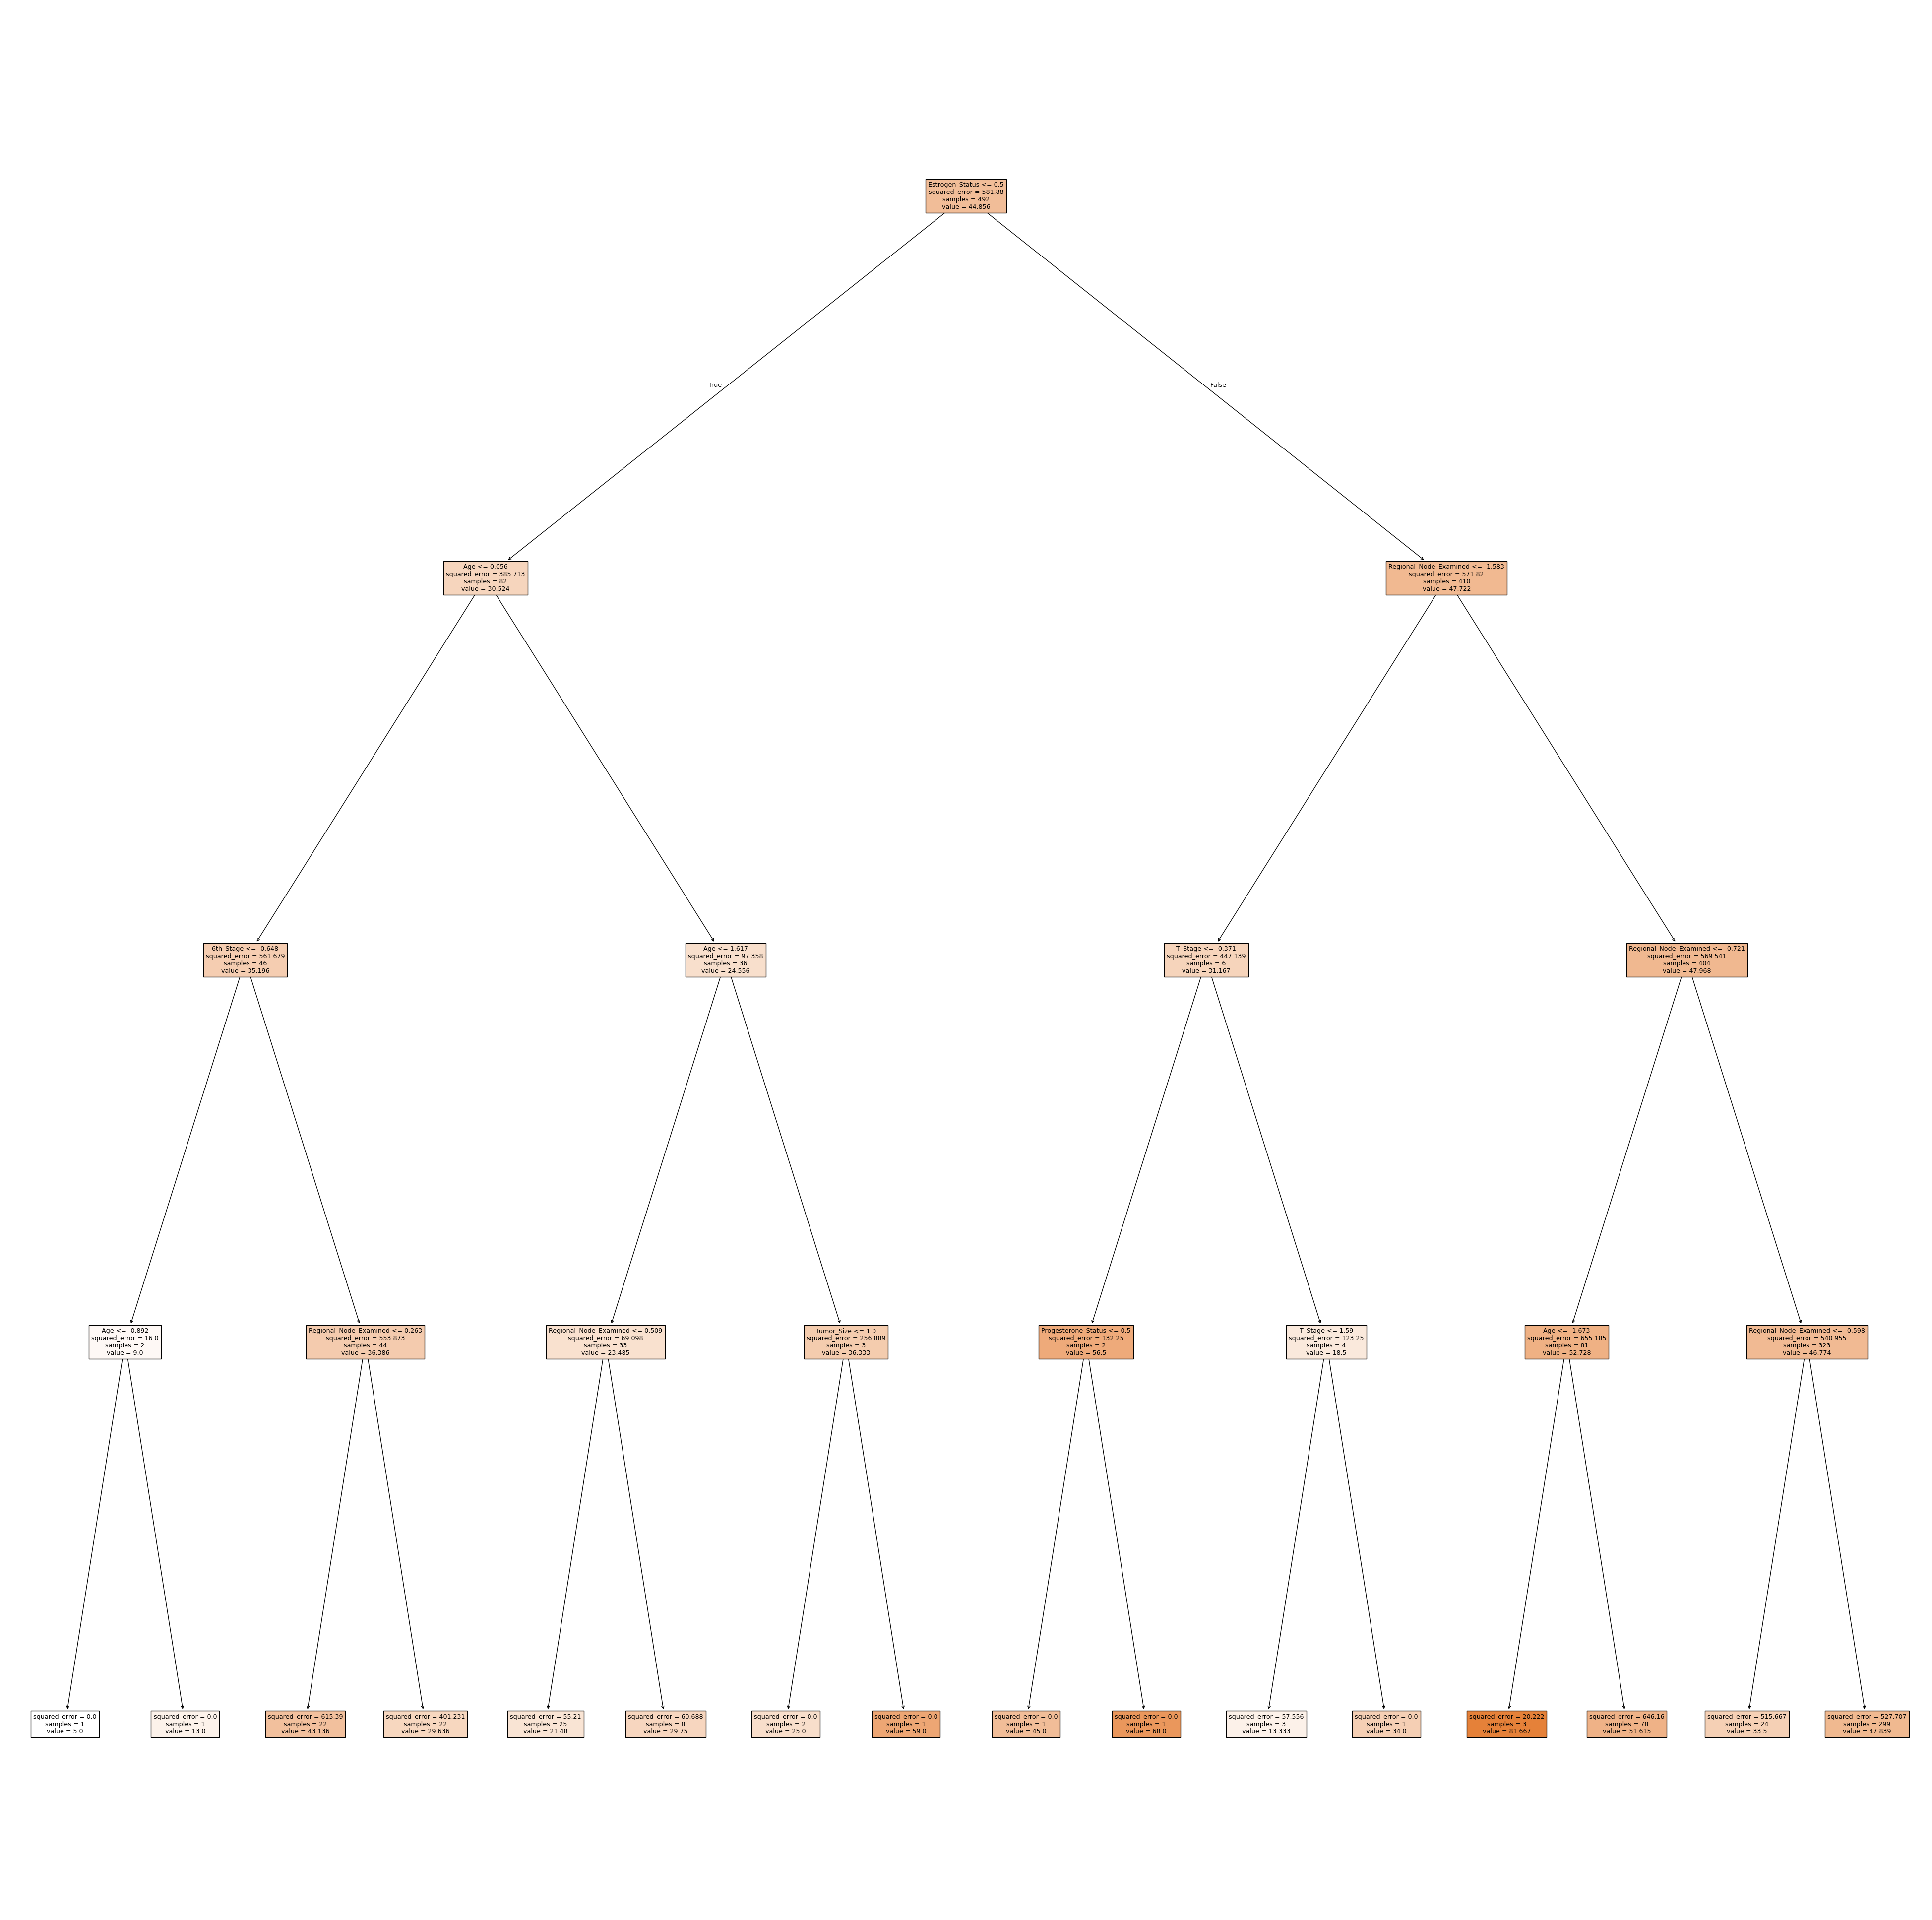

In [94]:
# making predictions for the test set
y_pred_pruned = pruned_regressor.predict(X_test)

# Plotting the regression DT
pruned_Tree_model = plt.figure(figsize=(50,50))
pruned_Tree_model_Graph = tree.plot_tree(pruned_regressor, feature_names=list(X_train.columns), filled=True)

# Saving the DT graph as a png image
pruned_Tree_model.savefig("pruned_reg_decision_tree.png")

Evaluating the fully grown DT

Reference:

Seminar 06 (week 07): page 20

In [95]:
# Calculating the regression metrics for the pruned regression decision Tree
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_pruned))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_pruned))
print('R2:', metrics.r2_score(y_test, y_pred_pruned))

Mean Absolute Error: 19.87145912176665
Mean Squared Error: 597.3107223280356
R2: -0.12178748822884655
